In [1]:
%matplotlib inline
import numpy as np
from openseespy.opensees import *
import openseespy.postprocessing.ops_vis as opsv
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import openseespy.postprocessing.Get_Rendering as opsplt
import ops_vis2 as opsv2
import handcalcs.render

# Enunciado

1. Realizar el análisis sísmico estático (4 puntos)
2. Incluir aportes de normas internacionales al análisis sísmico estático (4 puntos)
3. Realizar el análisis sísmico modal espectral (4 puntos)
4. Realizar el análisis sísmico tiempo-historia, incluyendo el escalamiento al espectro de diseño  (4 puntos)
5. Realizar el análisis comparativo y discusión de resultados (4 puntos)

In [2]:
# Unidades Base
m = 1
kg = 1
s = 1

# Otras Unidades
cm = 0.01*m
N = kg*m/s**2
kN = 1000*N
kgf = 9.80665*N
tonf = 1000*kgf
Pa = N/m**2

# Constantes Físicas
g = 9.80665*m/s**2

# Propiedades de los Materiales

In [3]:
fc = 210*kg/cm**2
E = 151*fc**0.5*kgf/cm**2
G = 0.5*E/(1+0.2)

# Densidad del concreto
ρ = 2400*kg/m**3

# Pre Dimensionado

In [4]:
%%render
#Dimensiones de la estructura

#Espaciado Ejes
dx=5.5*m #m
dy=5.5*m #m
dz=2.4*m #m

#Cantidad Ejes
nx=4
ny=4
nz=4 #se esta considerando la base tambien pisos+base
nnz=nz-1

#Capacidad Portante
q_a=4*kgf/cm**2    #N/m^2

<IPython.core.display.Latex object>

In [5]:
%%render
#Pre dimensionado de las vigas
peralteX=dx/11 #m
anchoX=peralteX/2 #m

peralteY=dy/11 #m
anchoY=peralteY/2 #m

<IPython.core.display.Latex object>

In [6]:
#Pre dimensionado de la losa
if(dx>dy):
    peralteLosa=dx/25
else:
    peralteLosa=dy/25

In [7]:
%%render
peralteLosa #m

<IPython.core.display.Latex object>

In [8]:
%%render
#Pre dimensionado de Columna
Tributaria_Centrica=dx*dy  #m^2
Tributaria_Excentrica=dx*dy*0.5 #m^2
Tributaria_Esquinas=dx*dy*0.25 #m^2

Peso=1250*kgf/m**2  #N/m^2
Area_Centrica=(Peso*nnz*Tributaria_Centrica)/(0.45*fc)  #m^2
Area_Excentrica=(Peso*nnz*Tributaria_Centrica)/(0.35*fc)  #m^2
Area_Esquinas=(Peso*nnz*Tributaria_Centrica)/(0.35*fc)  #m^2

<IPython.core.display.Latex object>

In [9]:
%%render
#Pre dimensionado de Zapatas
Area_zapata=(Peso*nnz*Tributaria_Centrica)/(0.9*q_a) #m^2

<IPython.core.display.Latex object>

# MODELADO CONVENCIONAL

# Propuesta de Secciones:

In [10]:
#Columnas
l1 = 0.55*m
l2=0.55*m

#Vigas
b = 0.25*m
h=0.50*m

#Losa
h_l=0.25*m

#Zapata
l_z=1.8*m 

In [11]:
# Viga
Av = b*h
Izv = b*h**3/12
Iyv = b**3*h/12
aa, bb = max(b,h),min(b,h)
β= 1/3-0.21*bb/aa*(1-(bb/aa)**4/12)
Jxxv = β*bb**3*aa

# Columna
Ac = l1*l2
Izc = l1*l2**3/12
Iyc = l2*l1**3/12
β= 1/3-0.21*1.*(1-(1.)**4/12)
Jxxc = β*l1**4

# Metrado de Cargas

In [12]:
%%render
#Cargas de Area
# Aplicando Cargas vivas y muertas
wLive = 250*kgf/m**2 #N/m^2
wLosa = 300*kgf/m**2 #N/m^2
wAcab = 100*kgf/m**2 #N/m^2
wTabi = 150*kgf/m**2 #N/m^2

#Peso por Paño
wtotal = (1.0*(wLosa+wAcab+wTabi)+0.25*wLive)*dx*dy   #N
w=(wtotal/g)  #kg

#Cargas de Viga
Peso_Viga=b*h*ρ*g*nnz*((ny-1)*dx+(nx-1)*dy) #N

#Cargas de Columna
Peso_Columna=l1*l2*ρ*g*nnz*(ny*nx)*dz #N

#Cargas de Losa
Peso_Losa=wtotal*nnz*(nx-1)*(ny-1) #N

Peso_Sismico=Peso_Viga+Peso_Columna+Peso_Losa #N

<IPython.core.display.Latex object>

# Geometria

In [13]:
wipe()
model("basic","-ndm",3,"-ndf",6)

#Extrude
ele_shapes={}
ex=0
scala=1

#Masas Nodales
mm=0
pesoNodal=0
for i in range(nz):
    for j in range(ny):
        for k in range(nx):
            node(mm,dx*k,dy*j,dz*i)
            if i!=0:
                if (k==(nx-1) or k==0) and (j==(ny-1) or j==0):
                    mass(mm,w*0.25,w*0.25,0)
                    pesoNodal=pesoNodal+w*0.25
                else:
                    if k==(nx-1) or k==0 or j==(ny-1) or j==0:
                        mass(mm,w*0.5,w*0.5,0)
                        pesoNodal=pesoNodal+w*0.5
                    else:
                        mass(mm,w,w,0)
                        pesoNodal=pesoNodal+w
            mm=mm+1
print(pesoNodal)
Diaphram="ON"
diafragmas=[]
if Diaphram=="ON":
    dirDia=3
    for i in range(nz-1):
        aux_nodos=[]
        diafragmas.append(mm)
        node(mm,(dx*(nx-1))/2,(dy*(ny-1))/2,dz*(i+1))
        fix(mm,*[0,0,1,1,1,0])
        for j in range(ny*nx):
            aux_nodos.append(j+nx*ny*(i+1))
        rigidDiaphragm(dirDia,mm,*aux_nodos)
        mm=mm+1
    
else:
    print("No se esta usando diafragma rigido")

fixZ(0,*[1,1,1,1,1,1],"-tol",1e-10)
print(diafragmas)

500259.375
[64, 65, 66]


In [14]:
#Vigas
mw=0
geomTransf('Corotational', 1, *[1,-1, 0])
cod_vig=[]

for i in range(nz-1):
    #Vigas en X
    for j in range(ny):
        for k in range(nx-1):
            element("elasticBeamColumn",mw,nx*ny*(i+1)+k+j*nx,nx*ny*(i+1)+k+j*nx+1,Av,E,G,Jxxv,Iyv*0.5,Izv*0.5,1,"-mass",ρ*Av)
            mw=mw+1
            ele_shapes[ex]=["rect",[b*scala,h*scala]]
            ex=ex+1
    #Vigas en Y
    for k in range(nx):
        for j in range(ny-1):
            element("elasticBeamColumn",mw,nx*ny*(i+1)+k+nx*j,nx*ny*(i+1)+nx*(j+1)+k,Av,E,G,Jxxv,Iyv*0.5,Izv*0.5,1,"-mass",ρ*Av)
            mw=mw+1
            ele_shapes[ex]=["rect",[b*scala,h*scala]]
            ex=ex+1

nro_vig=mw
#Columnas
geomTransf('Corotational', 2, *[1, 0, 0])

for i in range(nz-1):
    for j in range(ny):
        for k in range(nx):
            element("elasticBeamColumn",mw, k+nx*j+nx*ny*(i),k+nx*j+nx*ny*(i+1) ,Ac,E,G,Jxxc,Iyc*0.8,Izc*0.8,2,"-mass",ρ*Ac)
            mw=mw+1
            ele_shapes[ex]=["rect",[l1*scala,l2*scala]]
            ex=ex+1

<IPython.core.display.Javascript object>


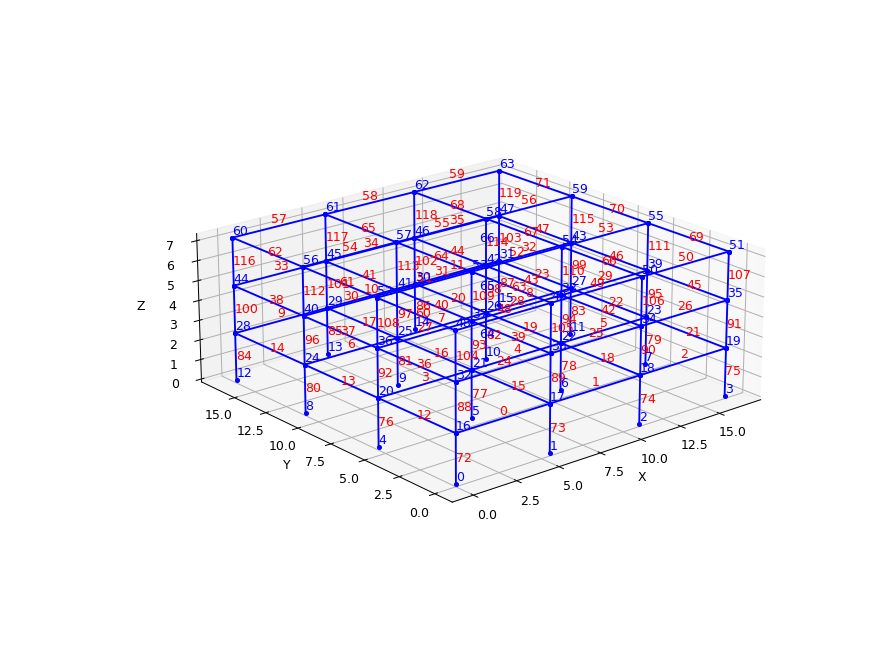

In [15]:
opsv.plot_model(fig_wi_he=(20,15),az_el=(-130,20))

<IPython.core.display.Javascript object>


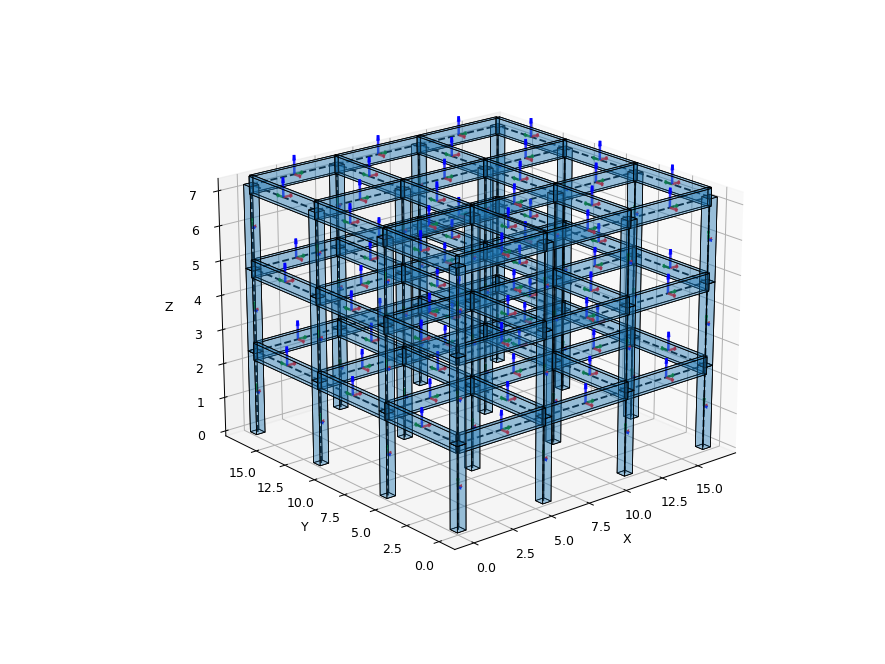

In [16]:
opsv.plot_extruded_shapes_3d(ele_shapes,fig_wi_he=(20,15),az_el=(-130,20))

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


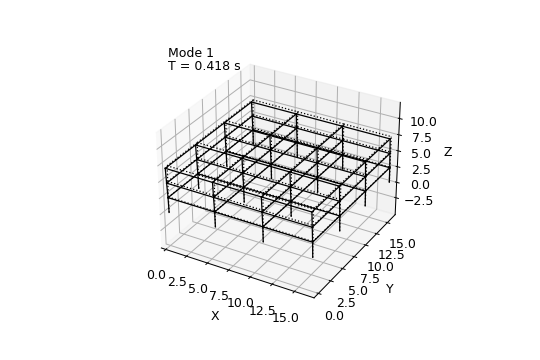

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


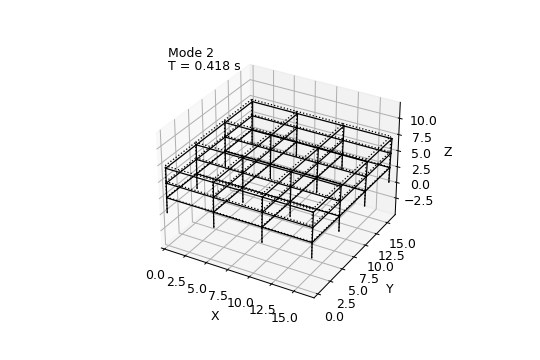

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


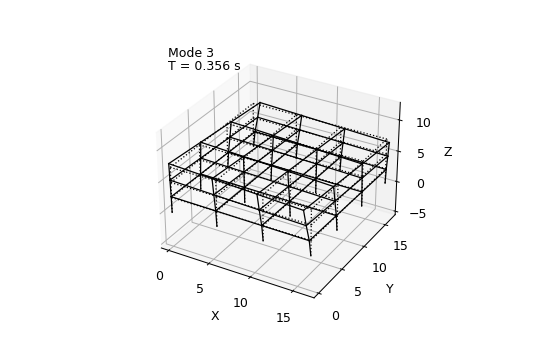

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


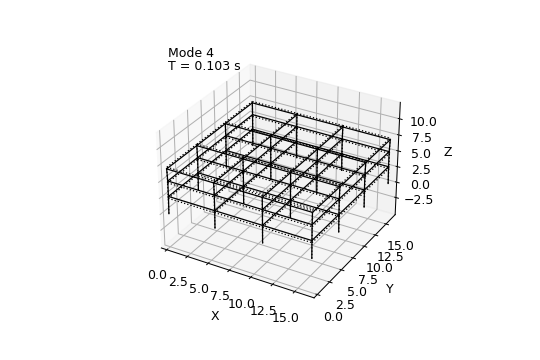

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


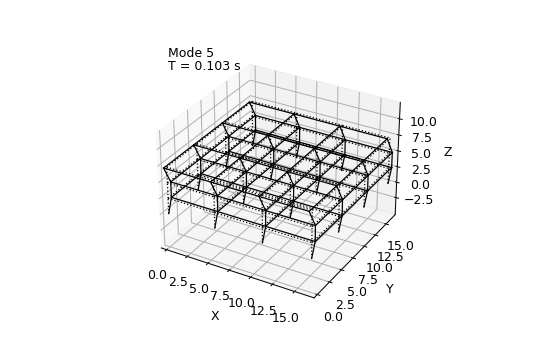

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


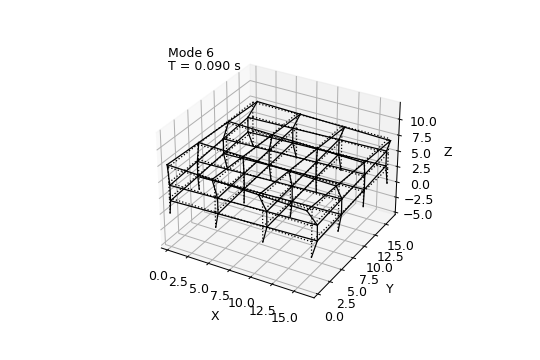

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


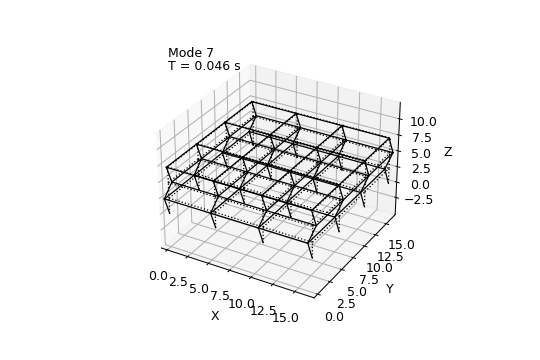

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


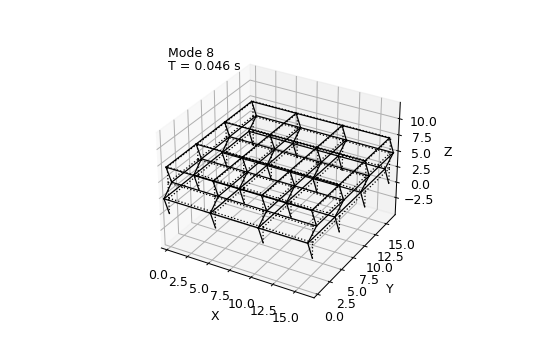

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


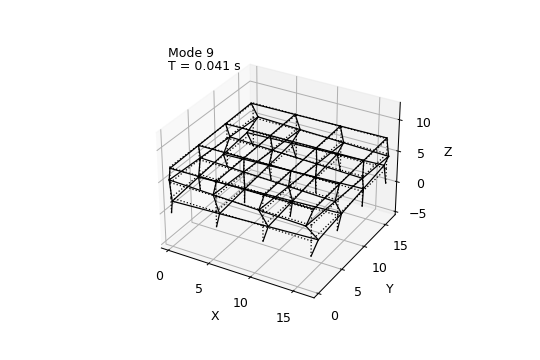

In [17]:
Nmodes=3*(nz-1)

for i in range(Nmodes):
    opsplt.plot_modeshape(i+1,300)

# Calculo de la Masa Sismica del Programa

In [18]:
wipeAnalysis()
constraints("Transformation")
numberer("Plain")
system("FullGeneral")
algorithm("Linear")
integrator("GimmeMCK",1,0,0)
analysis("Transient")
analyze(1,0)

N=systemSize()
Mmatrix=printA("-ret")
Mmatrix=np.array(Mmatrix).reshape((N,N))
#MF=Mmatrix[-3*nz:,-3*nz:]
MF=Mmatrix[-3*nnz:,-3*nnz:]

masss=0
for i in MF:
    masss=masss+sum(i)
print(masss)

42178171.921875


WARNING FullGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 1
WARNING Linear::solveCurrentStep() -the LinearSOE failed in solve()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 0
OpenSees > analyze failed, returned: -3 error flag


# Analisis Sismico Estatico 

In [19]:
Z=0.45   #Zona 4
U=1      #Edificacion Comun
S=1      #Suelo Rigido
Tp=0.4
Tl=2.5 
R=8      #APORTICADO

def Espectro(Tmodes,Z,U,S,Tp,Tl,R):
    psa=[0]*(Nmodes)
    for i in range(Nmodes):
        if Tmodes[i]<0:
            print("Error periodo negativo")
        else:
            if Tmodes[i]<=2.5:
                psa[i]=Z*U*2.5*S/R
            else:
                if Tmodes[i]<=Tl:
                    psa[i]=Z*U*2.5*(Tp/Tmodes[i])*S/R
                else:
                    psa[i]=Z*U*2.5*((Tp*Tl)/Tmodes[i]**2)*S/R
    return psa

def Estaticas(acel,masa,H):
    P=0
    masaT=0
    for i in range(nz-1):
        P=P+masa[i+1]*H[i]
        masaT=masaT+masa[i+1]
    V=[0]*(nz-1)
    for i in range(len(masa)-1):
        V[i]=(acel*masaT)*masa[i+1]*H[i]/P
    return V

In [20]:
vals=eigen(Nmodes)
Tmodes=np.zeros(len(vals))
for i in range(Nmodes):
    Tmodes[i]=2*np.pi/vals[i]**0.5
Tmodes=[0.32467215,0.32467215,0.28067172,0.0859342,0.0859342,0.07527575,0.04074074,0.04074074,0.03600929]
print(Tmodes)

[0.32467215, 0.32467215, 0.28067172, 0.0859342, 0.0859342, 0.07527575, 0.04074074, 0.04074074, 0.03600929]


In [21]:
#Alturas
H=[]
for i in range(1,nz):
    H.append(i*dz)
P = sum(MF[0::3,0::3])*9.80665 # Peso por nivel

masa=[0]
for i in range(len(P)):
    masa.append(P[i])
print(masa)

psa=Espectro(Tmodes,Z,U,S,Tp,Tl,R)
F=Estaticas(psa[0],masa,H)
print(F)

[0, 2297026.5846412536, 2297026.5846412536, 2160329.7289612517]
[163160.72509412418, 326321.45018824836, 460352.9197831559]


# Analisis Sismico en X

In [22]:
#Analisis Estatico en X
timeSeries("Linear",1)
pattern("Plain",1,1)
mm=mm-(nz-1)
Le=ny*dy*0.05
for i in range(nz-1):
    #print((i+1)*nx)
    load(mm,F[i],0.3*F[i],0,0,0,F[i]*Le)
    mm=mm+1

In [23]:
wipeAnalysis()
constraints("Transformation")
numberer("Plain")
system("FullGeneral")
algorithm("Linear")
integrator("LoadControl",1)
analysis("Static")
analyze(1)

0

In [24]:
VS = np.cumsum(F[::-1])[::-1]
print(VS)

[949835.09506553 786674.3699714  460352.91978316]


In [25]:
# Desplazamientos
df1 = pd.DataFrame(columns=['Nivel','Vx(kN)','UxMax(cm)','UyMax(cm)','DriftX(‰)','DriftY(‰)'])
tempX, tempY = 0., 0.
mm=mm-(nz-1)
for i in range(nnz):
    desX = nodeDisp(mm,1)
    desY = nodeDisp(mm,2)
    rotZ = nodeDisp(mm,6)
    desX = desX + abs(rotZ*ny*dy/2)
    desY = desY + abs(rotZ*nx*dx/2)
    desX, desY = desX*0.75*R, desY*0.75*R
    driftX = 1000.*(desX-tempX)/dz
    driftY = 1000.*(desY-tempY)/dz 
    tempX, tempY = desX, desY
    df1 = df1.append({'Nivel':i+1,'Vx(kN)':VS[i]/1000,'UxMax(cm)':desX*100,'UyMax(cm)':desY*100,
                    'DriftX(‰)':driftX,'DriftY(‰)':driftY}, ignore_index=True)
    mm=mm+1
print('\nANÁLISIS ESTÁTICO EN X')
print(df1.round(4))


ANÁLISIS ESTÁTICO EN X
   Nivel    Vx(kN)  UxMax(cm)  UyMax(cm)  DriftX(‰)  DriftY(‰)
0    1.0  949.8351     1.5024     0.5892     6.2601     2.4550
1    2.0  786.6744     4.1863     1.6381    11.1827     4.3705
2    3.0  460.3529     6.5744     2.5682     9.9505     3.8753


<IPython.core.display.Javascript object>


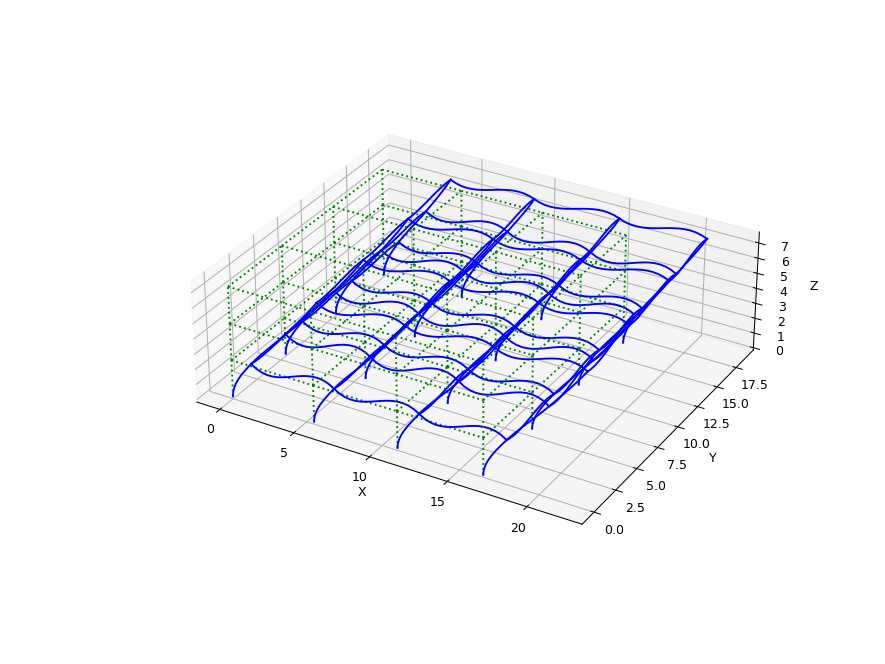

500

In [26]:
opsv.plot_defo(500,fig_wi_he=(20,15))

# Analisis Sismico en Y

In [27]:
#Analisis Estatico en Y
loadConst('-time', 0.0)
remove('timeSeries',1)
remove('loadPattern',1)

timeSeries("Linear",1)
pattern("Plain",1,1)
mm=mm-(nz-1)
Le=ny*dy*0.05
for i in range(nz-1):
    #print((i+1)*nx)
    load(mm,F[i]*0.3,F[i],0,0,0,F[i]*Le)
    mm=mm+1

In [28]:
wipeAnalysis()
constraints('Transformation')
numberer('Plain')
system('FullGeneral')
algorithm('Linear')
integrator('LoadControl',1)
analysis('Static')
analyze(1)

0

In [29]:
VS = np.cumsum(F[::-1])[::-1]

In [30]:
# Desplazamientos
df2 = pd.DataFrame(columns=['Nivel','Vy(kN)','UxMax(cm)','UyMax(cm)','DriftX(‰)','DriftY(‰)'])
tempX, tempY = 0., 0.
mm=mm-(nz-1)
for i in range(nnz):
    desX = nodeDisp(mm,1)
    desY = nodeDisp(mm,2)
    rotZ = nodeDisp(mm,6)
    desX = desX + abs(rotZ*ny*dy/2)
    desY = desY + abs(rotZ*nx*dx/2)
    desX, desY = desX*0.75*R, desY*0.75*R
    driftX = 1000.*(desX-tempX)/dz
    driftY = 1000.*(desY-tempY)/dz 
    tempX, tempY = desX, desY
    df2 = df2.append({'Nivel':i+1,'Vy(kN)':VS[i]/1000,'UxMax(cm)':desX*100,'UyMax(cm)':desY*100,
                    'DriftX(‰)':driftX,'DriftY(‰)':driftY}, ignore_index=True)
    mm=mm+1
print('\nANÁLISIS ESTÁTICO EN Y')
print(df2.round(4))


ANÁLISIS ESTÁTICO EN Y
   Nivel    Vy(kN)  UxMax(cm)  UyMax(cm)  DriftX(‰)  DriftY(‰)
0    1.0  949.8351     0.5894     1.5023     2.4559     6.2598
1    2.0  786.6744     1.6388     4.1858     4.3725    11.1813
2    3.0  460.3529     2.5694     6.5735     3.8772     9.9486


<IPython.core.display.Javascript object>


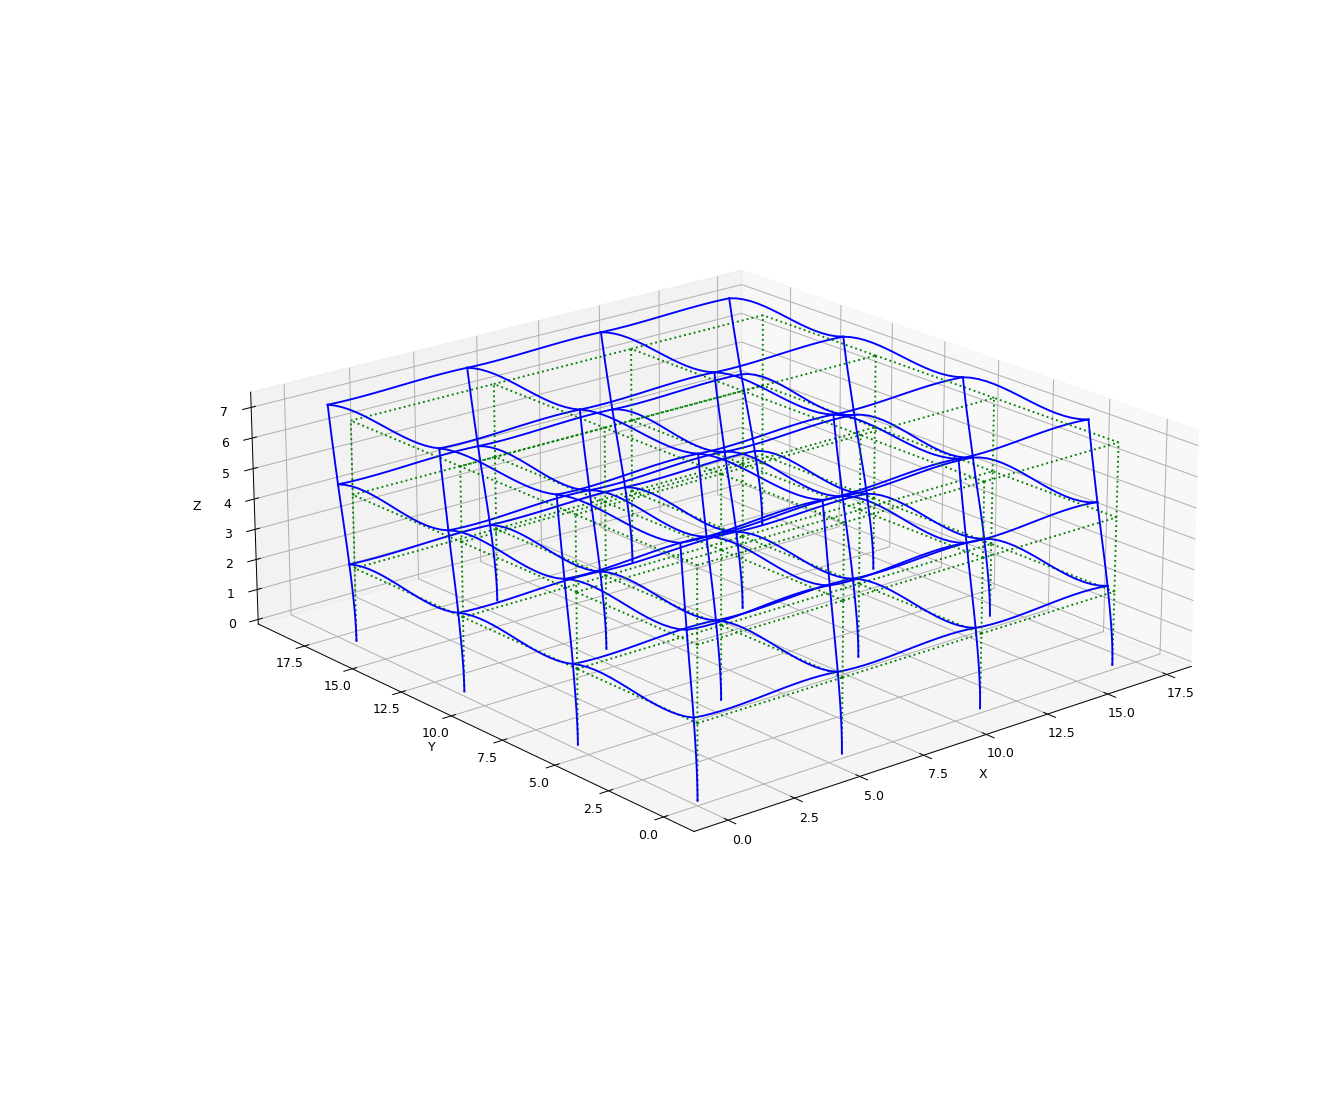

200

In [31]:
opsv.plot_defo(200,fig_wi_he=(30., 25.),az_el=(-130,20))

# Analisis Sismico Dinamico

# Calculo de Masas Efectivas

In [32]:
Tags = getNodeTags()
# print(Tags)
modo = np.zeros((Nmodes,3*nnz))

In [33]:
for j in range(1,Nmodes+1):
    ind = 0
    for i in Tags[-nnz:]:
        temp = nodeEigenvector(i,j)
        modo[j-1,[ind,ind+1,ind+2]] = temp[0],temp[1],temp[-1]
        ind = ind + 3

In [34]:
# Definimos valores iniciales
Ux,Uy,Rz = np.zeros(3*nnz),np.zeros(3*nnz),np.zeros(3*nnz)
Ux[0::3]=1
Uy[1::3]=1
Rz[2::3]=1
SUMx, SUMy, SUMr = 0., 0., 0.
ni = 0

In [35]:
Mx = sum(sum(MF[0::3,0::3]))
My = sum(sum(MF[1::3,1::3]))
Mr = sum(sum(MF[2::3,2::3]))

df3 = pd.DataFrame(columns=['Modo','T(s)','SumUx','SumUy','SumRz'])

In [36]:
for j in range(1,Nmodes+1):
    FPx = modo[j-1].T@MF@Ux
    FPy = modo[j-1].T@MF@Uy
    FPr = modo[j-1].T@MF@Rz
    FPRx = FPx**2/Mx
    FPRy = FPy**2/My
    FPRr = FPr**2/Mr
    SUMx = SUMx + FPRx
    SUMy = SUMy + FPRy
    SUMr = SUMr + FPRr
    #
    if min(SUMx,SUMy,SUMr)>=0.90 and ni==0:
        ni = j
    df3 = df3.append({'Modo':j, 'T(s)':Tmodes[j-1],'SumUx':SUMx,
                    'SumUy':SUMy,'SumRz':SUMr}, ignore_index=True)
print(df3.round(5))
print('N° mínimo de Modos a considerar:',ni)

   Modo     T(s)    SumUx    SumUy    SumRz
0   1.0  0.32467  0.00019  0.78912  0.00000
1   2.0  0.32467  0.78930  0.78930  0.00000
2   3.0  0.28067  0.78930  0.78930  0.79267
3   4.0  0.08593  0.94788  0.79177  0.79267
4   5.0  0.08593  0.95034  0.95034  0.79267
5   6.0  0.07528  0.95034  0.95034  0.95078
6   7.0  0.04074  0.97625  0.97409  0.95078
7   8.0  0.04074  1.00000  1.00000  0.95078
8   9.0  0.03601  1.00000  1.00000  1.00000
N° mínimo de Modos a considerar: 6


In [37]:
def CombinacionModal(E030,MF,modo,Tmodes,NT,ni):

    # Definimos valores iniciales
    D_ABSx,D_RCSCx = np.zeros(NT),np.zeros(NT)
    Δ_ABSx,Δ_RCSCx = np.zeros(NT),np.zeros(NT)
    V_ABSx,V_RCSCx = np.zeros(NT),np.zeros(NT)
    D_ABSy,D_RCSCy = np.zeros(NT),np.zeros(NT)
    Δ_ABSy,Δ_RCSCy = np.zeros(NT),np.zeros(NT)
    V_ABSy,V_RCSCy = np.zeros(NT),np.zeros(NT)

    # Se realiza la Superpocisión Modal Espectral
    for j in range(1,ni+1):#ni+1
        FPx=modo[j-1].T@MF@Ux
        FPy=modo[j-1].T@MF@Uy
        FPr=modo[j-1].T@MF@Rz
        #
        Sa = E030[j-1]*9.80665
        Sd = Sa/(2*np.pi/Tmodes[j-1])**2
        #
        respDX = Sd*FPx*modo[j-1]
        respAX = Sa*FPx*MF@modo[j-1]
        D_ABSx = D_ABSx + abs(respDX)
        D_RCSCx = D_RCSCx + (respDX)**2
        respDX[3:] = respDX[3:] - respDX[:-3]
        Δ_ABSx = Δ_ABSx + abs(respDX)
        Δ_RCSCx = Δ_RCSCx + (respDX)**2
        V_ABSx = V_ABSx + abs(np.cumsum(respAX[::-1])[::-1])
        V_RCSCx = V_RCSCx + (np.cumsum(respAX[::-1])[::-1])**2
        #
        respDY = Sd*FPy*modo[j-1]
        respAY = Sa*FPy*MF@modo[j-1]
        D_ABSy = D_ABSy + abs(respDY)
        D_RCSCy = D_RCSCy + (respDY)**2
        
        respDY[3:] = respDY[3:] - respDY[:-3]
        Δ_ABSy = Δ_ABSy + abs(respDY)
        Δ_RCSCy = Δ_RCSCy + (respDY)**2
        V_ABSy = V_ABSy + abs(np.cumsum(respAY[::-1])[::-1])
        V_RCSCy = V_RCSCy + (np.cumsum(respAY[::-1])[::-1])**2

    # Se realiza la combinación 25%ABS + 75%RCSC
    D_RCSCx = D_RCSCx**0.5
    Δ_RCSCx = Δ_RCSCx**0.5
    V_RCSCx = V_RCSCx**0.5
    DDx = 0.25*D_ABSx + 0.75*D_RCSCx
    ΔDx = 0.25*Δ_ABSx + 0.75*Δ_RCSCx
    VDx = 0.25*V_ABSx + 0.75*V_RCSCx
    #
    D_RCSCy = D_RCSCy**0.5
    Δ_RCSCy = Δ_RCSCy**0.5
    V_RCSCy = V_RCSCy**0.5
    DDy = 0.25*D_ABSy + 0.75*D_RCSCy
    ΔDy = 0.25*Δ_ABSy + 0.75*Δ_RCSCy
    VDy = 0.25*V_ABSy + 0.75*V_RCSCy
    
    df = pd.DataFrame(columns=['Nivel','VDx(kN)','VDy(kN)','UDx(cm)','UDy(cm)','Δx(‰)','Δy(‰)'])
    for i in range(int(NT/3)): #CAMBIO
        df = df.append({'Nivel':i, 'VDx(kN)':VDx[0::3][i]/1000,
        'VDy(kN)':VDy[1::3][i]/1000,'UDx(cm)':DDx[0::3][i]*100,
        'UDy(cm)':DDy[1::3][i]*100,'Δx(‰)':ΔDx[0::3][i]*0.75*R*1000/dz,'Δy(‰)':ΔDy[1::3][i]*0.75*R*1000/dz}, ignore_index=True)

    return DDx, ΔDx, VDx, DDy, ΔDy, VDy, df

In [38]:
DDx, ΔDx, VDx, DDy, ΔDy, VDy, df4 = CombinacionModal(psa,MF,modo,Tmodes,3*nnz,ni)
print('\nANÁLISIS DINÁMICO SIN ESCALAR')
df4 = df4.astype({'Nivel':int})
print(df4.round(4))


ANÁLISIS DINÁMICO SIN ESCALAR
   Nivel   VDx(kN)   VDy(kN)  UDx(cm)  UDy(cm)   Δx(‰)   Δy(‰)
0      0  801.9924  811.1493   0.1095   0.1095  2.7370  2.7370
1      1  654.7398  676.0136   0.3034   0.3034  4.8547  4.8547
2      2  437.8477  432.8118   0.4783   0.4783  4.5285  4.5285


In [39]:
# Escalamiento de los resultados del análisis dinámico
if VDx[0::3][0]<0.80*VS[0]:
    FSx  = 0.80*VS[0]/VDx[0::3][0]
    msjx = 'SI es necesario aplicar un Factor de Escala en X: %.4f'%FSx
else:
    FSx = 1.
    msjx = 'NO es necesario escalar en X'

if VDy[1::3][0]<0.80*VS[0]:
    FSy  = 0.80*VS[0]/VDy[1::3][0]
    msjy = 'SI es necesario aplicar un Factor de Escala en Y: %.4f'%FSy
else:
    FSy = 1.
    msjy = 'NO es necesario escalar en Y'

texto1 = '\nAl comparar la cortante basal obtenida en el análisis dinámico en X \n\
(%.2f kN) y el 80%% de la cortante basal del análisis estático en X (%.2f kN), \n\
se obtiene que %s. '%(VDx[0::3][0]/1000,0.80*VS[0]/1000,msjx)
texto1 = texto1 + '\nEn la dirección Y, la cortante basal obtenida en el análisis \n\
dinámico es %.2f kN y el 80%% de la cortante basal del análisis estático es %.2f kN. \n\
Por lo que %s.'%(VDy[1::3][0]/1000,0.80*VS[0]/1000,msjy)
print(texto1)


Al comparar la cortante basal obtenida en el análisis dinámico en X 
(801.99 kN) y el 80% de la cortante basal del análisis estático en X (759.87 kN), 
se obtiene que NO es necesario escalar en X. 
En la dirección Y, la cortante basal obtenida en el análisis 
dinámico es 811.15 kN y el 80% de la cortante basal del análisis estático es 759.87 kN. 
Por lo que NO es necesario escalar en Y.


In [40]:
# Se aplican los Factores de Escala
print('\nANÁLISIS DINÁMICO FINAL')
df5 = pd.DataFrame(columns=['Nivel','Vx(kN)','Vy(kN)','Ux(cm)','Uy(cm)','Δx(‰)','Δy(‰)'])
for i in range(nnz):
    Δx = 0.75*R*ΔDx[0::3][i]/dz
    Δy = 0.75*R*ΔDy[1::3][i]/dz
    #
    df5 = df5.append({'Nivel':i+1, 'Vx(kN)':FSx*VDx[0::3][i]/1000,
        'Vy(kN)':FSy*VDy[1::3][i]/1000,'Ux(cm)':0.75*R*DDx[0::3][i]*100,
        'Uy(cm)':0.75*R*DDy[1::3][i]*100,'Δx(‰)':Δx*1000,'Δy(‰)':Δy*1000}, ignore_index=True)
df5 = df5.astype({'Nivel':int})
print(df5.round(4))


ANÁLISIS DINÁMICO FINAL
   Nivel    Vx(kN)    Vy(kN)  Ux(cm)  Uy(cm)   Δx(‰)   Δy(‰)
0      1  801.9924  811.1493  0.6569  0.6569  2.7370  2.7370
1      2  654.7398  676.0136  1.8202  1.8202  4.8547  4.8547
2      3  437.8477  432.8118  2.8697  2.8697  4.5285  4.5285


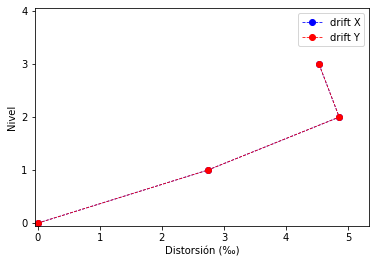

In [41]:
%matplotlib inline
# Ploteamos las Distorsiones
vecX = np.array(df5.loc[:,'Δx(‰)'])
vecY = np.array(df5.loc[:,'Δy(‰)'])
lim = 1.1*max(vecX.max(),vecY.max())
#
plt.plot(np.insert(vecX,0,0),np.arange(nz),'bo--',label='drift X',lw = 0.8)
plt.plot(np.insert(vecY,0,0),np.arange(nz),'ro--',label='drift Y',lw = 0.8)
plt.legend()
plt.xlabel('Distorsión (‰)')
plt.ylabel('Nivel')
plt.axis([-0.05,lim,-0.05,nz+0.05])
plt.yticks(np.arange(0, nz+0.05, 1))
plt.show()